In [1]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import cv2
import random

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [3]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
Pos_path=os.path.join('data','positive')
Neg_path=os.path.join('data','negative')
Anchor_path=os.path.join('data','anchor')

In [6]:
import os

try:
    os.makedirs(Pos_path, exist_ok=True)
    os.makedirs(Neg_path, exist_ok=True)
    os.makedirs(Anchor_path, exist_ok=True)
    print("Directories created successfully.")
except Exception as e:
    print("Error creating directory:", e)


Directories created successfully.


In [7]:
import tensorflow_datasets as tfds

# Download and load the LFW dataset
dataset, info = tfds.load('lfw', split='train', with_info=True)

# Print dataset information
print(info)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/lfw/incomplete.R4FZ06_0.1.1/lfw-train.tfrecord*...:   0%|          | 0/132…

Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='lfw',
    full_name='lfw/0.1.1',
    description="""
    Labeled Faces in the Wild: A Database for Studying Face Recognition in
    Unconstrained Environments
    """,
    homepage='http://vis-www.cs.umass.edu/lfw',
    data_dir='/root/tensorflow_datasets/lfw/0.1.1',
    file_format=tfrecord,
    download_size=172.20 MiB,
    dataset_size=180.28 MiB,
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=uint8),
        'label': Text(shape=(), dtype=string),
    }),
    supervised_keys=('label', 'image'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=13233, num_shards=2>,
    },
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A

In [8]:
# Create a function to save images from the dataset
def save_images_to_directory(dataset, directory):
    # Iterate through the dataset
    for i, example in enumerate(dataset):
        # Get the image and convert it to a NumPy array
        image = example['image'].numpy()
        # Get the label (optional, but useful for potential organization)
        label = example['label'].numpy().decode('utf-8')

        # Create a filename based on the index and label
        filename = os.path.join(directory, f'{label}_{i}.jpg')

        # Save the image
        cv2.imwrite(filename, image)

# Save the images from the dataset to the negative directory
save_images_to_directory(dataset, Neg_path)

print(f"Images from the dataset saved to {Neg_path}")

Images from the dataset saved to data/negative


In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(4)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]

    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path
        imgname = os.path.join(Anchor_path, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)

    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path
        imgname = os.path.join(Pos_path, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)

    # Show image back to screen
    cv2.imshow('Image Collection', frame)

    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [9]:
anchor = tf.data.Dataset.list_files(Anchor_path+'/*.jpg').take(200)
positive = tf.data.Dataset.list_files(Pos_path+'/*.jpg').take(200)
negative = tf.data.Dataset.list_files(Neg_path+'/*.jpg').take(200)

In [10]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

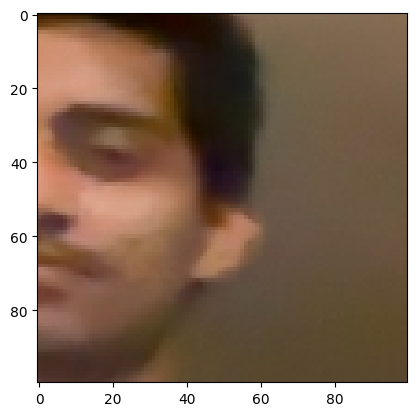

In [13]:
plt.imshow(preprocess(anchor.as_numpy_iterator().next()))

In [14]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [15]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [16]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [17]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [18]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [19]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [20]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [24]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image)[0], embedding(validation_image)[0])

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [25]:
siamese_model=make_siamese_model()

In [26]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [27]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [28]:
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir,exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [29]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

In [30]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [31]:
train(train_data,50)


 Epoch 1/50
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/stepTensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 300ms/step

 Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step

 Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step

 Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step

 Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step

 Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step

 Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step

 Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step

 Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step

 Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step

 Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step

 Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step

 Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step

 Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms

In [33]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])
[1 if prediction > 0.5 else 0 for prediction in y_hat ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]

In [34]:
y_true

array([1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.],
      dtype=float32)

In [35]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

np.float32(1.0)

In [36]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

np.float32(1.0)

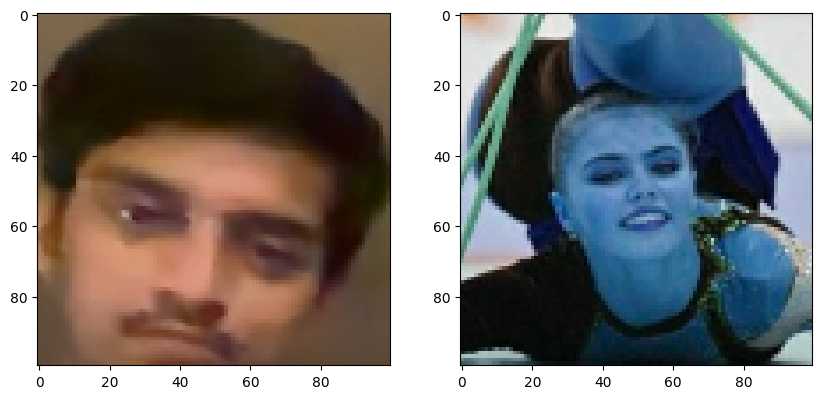

In [39]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[2])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Renders cleanly
plt.show()

In [40]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [41]:
model = tf.keras.models.load_model('siamesemodel.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [42]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[9.9998116e-01],
       [9.9999321e-01],
       [4.0838825e-07],
       [1.0404414e-06],
       [8.7544571e-08],
       [3.5425132e-06],
       [7.8358300e-07],
       [2.7000283e-06],
       [1.0000000e+00],
       [1.5428641e-07],
       [9.3824410e-06],
       [8.5083670e-08],
       [1.0000000e+00],
       [1.0000000e+00],
       [4.2291546e-07],
       [3.0866026e-08]], dtype=float32)

In [43]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)